## Augment Missing Data in LitPop with Geg-15

There are some missing countries in LitPop. This notebook fills in those areas with Geg-15 and saves the grid as a single parquet file.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from math import ceil

import dask.dataframe as ddf
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy_groupies as npg
import pandas as pd
import regionmask
import xarray as xr
import xesmf as xe
from cartopy import crs as ccrs
from dask_gateway import Gateway
from sliiders import settings as sset
from sliiders.io import save
from sliiders.spatial import grid_ix_to_val, grid_val_to_ix

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [3]:
N_WORKERS = 14

In [5]:
gateway = Gateway()
cluster = gateway.new_cluster(profile="micro", idle_timeout=1800)
cluster.adapt(minimum=7, maximum=N_WORKERS)
client = cluster.get_client()
cluster

## Load Datasets

In [4]:
valid_ccodes = np.concatenate(
    (pd.read_parquet(sset.PATH_ALL_VALID_HIST_CCODES).ccode.values, sset.EXCLUDED_ISOS)
)
final_ccodes = [
    v
    for v in valid_ccodes
    if "+" not in v and v not in sset.EXCLUDED_ISOS and v not in sset.UNINHABITED_ISOS
]

In [9]:
litpop = (
    ddf.read_csv(
        str(sset.PATH_LITPOP_RAW),
        dtype={"value": "float32", "lat": "float32", "lon": "float32"},
        storage_options={"token": str(sset.CRED_PATH)},
    )
    .rename(columns={"latitude": "lat", "longitude": "lon"})
    .repartition(npartitions=N_WORKERS)
    .persist()
)
litpop_meta = pd.read_csv(sset.DIR_LITPOP_RAW / "_metadata_countries_v1_2.csv").replace(
    {"iso3": {"XKX": "XKO"}}
)
assert litpop_meta.iso3.isin(valid_ccodes).all()

region_id_to_iso = litpop_meta.set_index("region_id").iso3

litpop = litpop.join(region_id_to_iso, on="region_id").persist()

## Understand missingness

In [8]:
def plot_exposure(ax, title, data, poly, buffer=1, vmin=None, vmax=None):
    ax.set_extent(
        [
            poly.bounds[0] - buffer,
            poly.bounds[2] + buffer,
            poly.bounds[1] - buffer,
            poly.bounds[3] + buffer,
        ]
    )
    ax.coastlines("10m", linewidth=0.5, edgecolor="tab:orange")

    # ax.add_feature(adm0, edgecolor="tab:orange", linewidth=0.1)
    ax.add_geometries(
        [poly], ccrs.PlateCarree(), facecolor="none", edgecolor="r", linewidth=0.3
    )

    data = data.where(data > 0.0000001)

    if data.isnull().all():
        ax.set_title(title)
        print(title)
        return

    data["lon"] = grid_val_to_ix(data.lon, sset.ASSET_VALUE_GRID_WIDTH, lon_mask=True)
    data["lat"] = grid_val_to_ix(data.lat, sset.ASSET_VALUE_GRID_WIDTH, lon_mask=False)
    data = data.reindex(
        lon=np.arange(data.lon.min(), data.lon.max() + 1),
        lat=np.arange(data.lat.min(), data.lat.max() + 1),
    )
    data["lon"] = grid_ix_to_val(data.lon, sset.ASSET_VALUE_GRID_WIDTH, lon_mask=True)
    data["lat"] = grid_ix_to_val(data.lat, sset.ASSET_VALUE_GRID_WIDTH, lon_mask=False)

    try:
        data.plot(
            cmap="YlGnBu",
            norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax),
            ax=ax,
            cbar_kwargs={"shrink": 0.5, "label": ""},
        )
    except Exception:
        print(title)

    ax.set_title(title)


def plot_exposure_multi(isos, bounds, buffer=1):
    nrows = ceil(len(isos) / 3)
    fig, axs = plt.subplots(
        figsize=((3 * 3), (3 * nrows)),
        dpi=500,
        ncols=3,
        nrows=nrows,
        subplot_kw={"projection": ccrs.PlateCarree()},
    )

    axs = axs.flatten()
    for ix, iso in enumerate(isos):
        geoms
        ax = axs[ix]
        geom = geoms.loc[iso]
        this_bds = bounds.loc[iso]

        litpop_sub = (
            litpop[
                (litpop.lon >= this_bds.minx - 0.01)
                & (litpop.lon <= this_bds.maxx + 0.01)
                & (litpop.lat >= this_bds.miny - 0.01)
                & (litpop.lat <= this_bds.maxy + 0.01)
            ]
            .compute()
            .set_index(["lat", "lon"])
            .to_xarray()
        )

        plot_exposure(ax, iso, litpop_sub.value, geom, buffer=buffer)

In [8]:
all_missing = np.setdiff1d(
    final_ccodes, litpop_meta.loc[litpop_meta.included.eq(1), "iso3"]
)
geoms = gpd.read_parquet(sset.PATH_GADM_ADM0_INT).geometry

bds = geoms.loc[all_missing].bounds

CCK
CXR
IOT
PCN


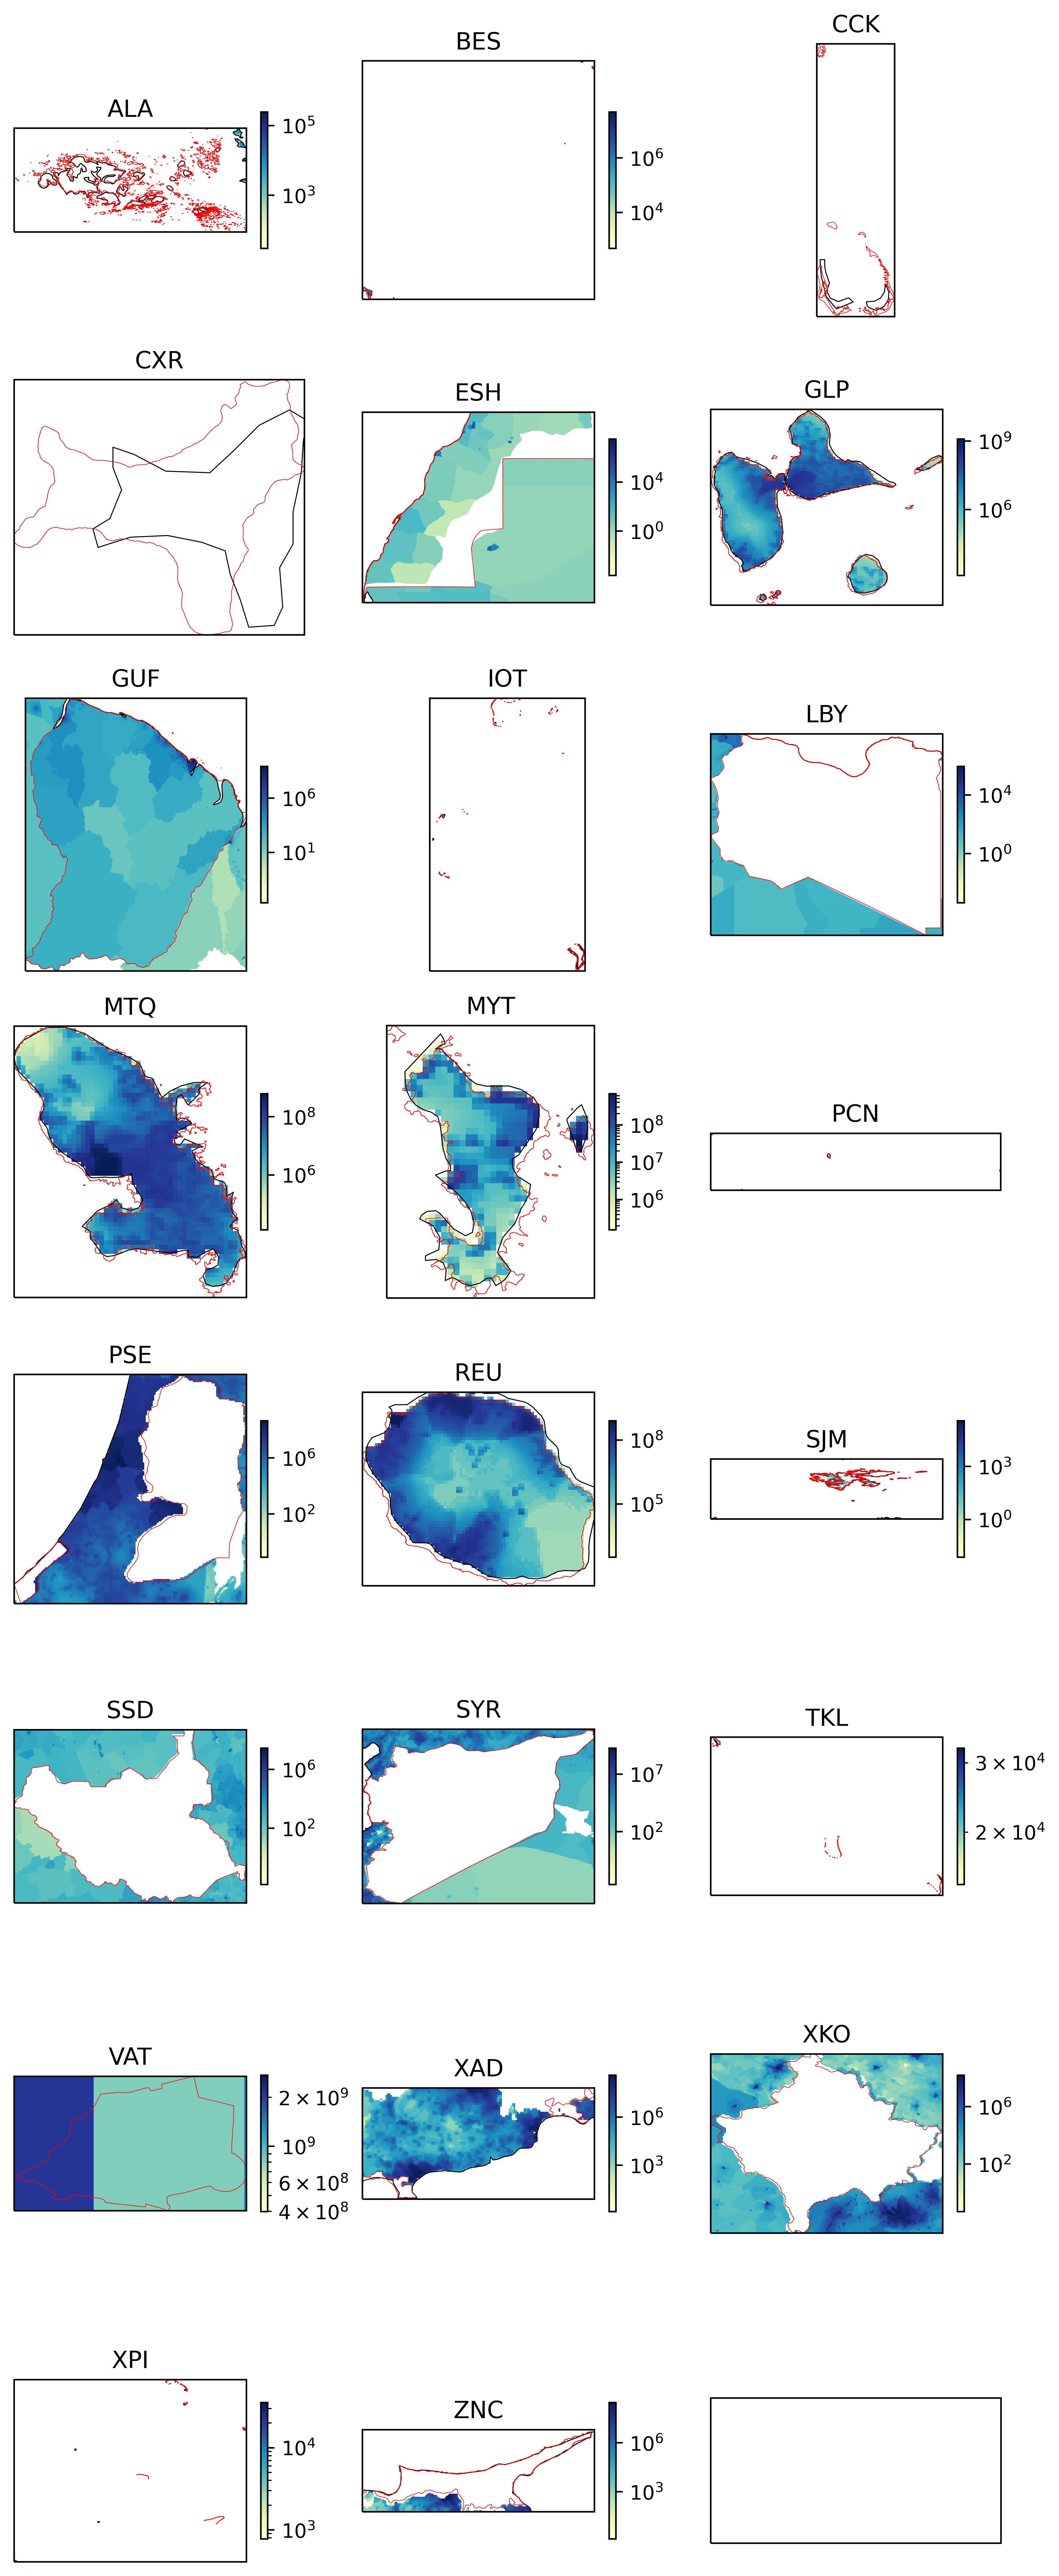

In [9]:
plot_exposure_multi(all_missing, bds, buffer=0)

Some "countries" that seemed to be missing are really just territories treated as part of the sovereign in LitPop. Others will actually need to be filled. The countries that look like they need to be filled:

In [10]:
lp_missing_isos = [
    "ALA",
    "CCK",
    "CXR",
    "IOT",
    "LBY",
    "PCN",
    "PSE",
    "SSD",
    "SYR",
    "XAD",
    "XKO",
    "XPI",
    "ZNC",
]

## Helper Functions

In [11]:
def poly_mask(poly, grid):
    mask = xr.DataArray(
        1, coords={"lat": grid.lat, "lon": grid.lon}, dims=["lat", "lon"]
    )

    mask = mask.rio.set_spatial_dims(x_dim="lon", y_dim="lat").rio.write_crs(
        "epsg:4326"
    )

    return (mask.rio.clip([poly], drop=False, all_touched=True) == 1).drop(
        "spatial_ref"
    )


# retrieve geg data to regrid
def subset_relevant_geg_data(poly, geg15, buffer=1 / 48):
    # subset geg for buffered country poly bounds
    geg15_sub = geg15[
        (geg15.lon >= poly.bounds[0] - buffer)
        & (geg15.lon <= poly.bounds[2] + buffer)
        & (geg15.lat >= poly.bounds[1] - buffer)
        & (geg15.lat <= poly.bounds[3] + buffer)
    ][["lon", "lat", "tot_val"]].reset_index(drop=True)

    if geg15_sub.shape[0] == 0:
        return None

    subset = geg15_sub.set_index(["lat", "lon"]).to_xarray()

    subset["mask"] = poly_mask(poly, subset)

    if subset.tot_val.where(subset.mask).sum() <= 0:
        return None

    return subset


def create_grid(subset, resolution, add_cell_corners=False):

    masked_lon = subset.lon.where((subset.mask > 0) & (subset.tot_val.notnull()))
    masked_lat = subset.lat.where((subset.mask > 0) & (subset.tot_val.notnull()))

    # construct destination grid with mask holder variable
    x1, y1 = np.floor((masked_lon.lon.min().item(), masked_lat.lat.min().item()))
    x2, y2 = np.ceil((masked_lon.lon.max().item(), masked_lat.lat.max().item()))

    lat = np.arange(y1 + resolution / 2, y2, resolution)
    lon = np.arange(x1 + resolution / 2, x2, resolution)

    ds_out = xr.Dataset(
        coords={
            "lat": lat,
            "lon": lon,
        }
    )

    if add_cell_corners:
        ds_out.coords["lat_b"] = (ds_out.lat.min().item() - resolution / 2) + np.arange(
            len(ds_out.lat) + 1
        ) * resolution
        ds_out.coords["lon_b"] = (ds_out.lon.min().item() - resolution / 2) + np.arange(
            len(ds_out.lon) + 1
        ) * resolution

    return ds_out


def make_land_weights(subset, poly, out_resolution, in_resolution):

    print("Creating grids...")
    # create grid at out_resolution with grid cell edges at a whole lat and lon values
    out_grid = create_grid(subset, resolution=out_resolution, add_cell_corners=True)

    # create grid at in_resolution with grid cell edges at a whole lat and lon values
    in_grid = create_grid(subset, resolution=in_resolution, add_cell_corners=True)

    # create grid cell id for in_grid
    in_grid["id5x"] = (
        ["lat", "lon"],
        np.arange(in_grid.lat.shape[0] * in_grid.lon.shape[0]).reshape(
            (in_grid.lat.shape[0], in_grid.lon.shape[0])
        ),
    )

    # apply in_grid grid cell id to out_grid cells
    out_grid["idx5"] = in_grid.reindex_like(
        out_grid, method="nearest", tolerance=in_resolution / 2
    ).id5x

    print("Creating land mask...")
    out_grid["mask"] = (
        regionmask.Regions([poly], numbers=[1])
        .mask(out_grid.lon.values, out_grid.lat.values)
        .fillna(0)
    )

    print("Constructing land weights...")
    in_grid["land_weights"] = (
        ["lat", "lon"],
        npg.aggregate(
            group_idx=out_grid.idx5.values.flatten(),
            a=out_grid.mask.values.flatten(),
            fill_value=0,
            func="sum",
        ).reshape(in_grid.id5x.shape)
        / ((in_resolution / out_resolution) ** 2),
    )

    return in_grid


def prep_geg_for_regrid(
    poly, geg15, geg_res=sset.GEG_GRID_WIDTH, litpop_res=sset.ASSET_VALUE_GRID_WIDTH
):

    # get relevant geg data given poly of interest
    subset = subset_relevant_geg_data(poly, geg15, geg_res / 2)
    if subset is None:
        return None

    # construct land weights
    weights = make_land_weights(subset, poly, litpop_res, geg_res)

    # add corners for conservative regrid
    subset.coords["lat_b"] = (subset.lat.min().item() - geg_res / 2) + np.arange(
        len(subset.lat) + 1
    ) * geg_res
    subset.coords["lon_b"] = (subset.lon.min().item() - geg_res / 2) + np.arange(
        len(subset.lon) + 1
    ) * geg_res

    # regrid landweights onto geg grid
    regridder = xe.Regridder(weights, subset, "conservative")
    land_weights_regrid = regridder(weights)

    # normalize using amount of land per cell
    weights = geg_res**2
    subset["tot_val_norm"] = (
        subset.tot_val.where(land_weights_regrid.land_weights > 0) / weights
    )

    # drop out if all null data --> no asset value on relevant land
    if (
        subset.tot_val_norm.where((subset.mask > 0) & subset.tot_val_norm.notnull())
        .notnull()
        .sum()
        == 0
    ):
        return None

    return subset


def regrid_geg(
    poly, geg15, geg_res=sset.GEG_GRID_WIDTH, litpop_res=sset.ASSET_VALUE_GRID_WIDTH
):

    geg_sub = prep_geg_for_regrid(poly, geg15, geg_res, litpop_res)

    if geg_sub is None:
        return None

    out_grid = create_grid(geg_sub, resolution=litpop_res)

    regridder = xe.Regridder(geg_sub, out_grid, "nearest_s2d")

    geg_regridded = regridder(geg_sub)

    geg_regridded["tot_val"] = (geg_regridded.tot_val_norm * (litpop_res**2)).where(
        poly_mask(poly, geg_regridded[["lat", "lon"]])
    )

    return geg_regridded

## Regrid GEG for Missing Countries in LitPop

In [12]:
geg15 = (
    pd.read_parquet(sset.PATH_GEG15_INT, columns=["tot_val"])
    .tot_val.reset_index()
    .drop(columns="iso3")
)

In [13]:
out_dict = {}
for iso in lp_missing_isos:
    print(iso)
    territory_shape = geoms[iso]
    out_dict[iso] = regrid_geg(territory_shape, geg15)

ALA
Creating grids...
Creating land mask...
Constructing land weights...
CCK
CXR
IOT
LBY
Creating grids...
Creating land mask...
Constructing land weights...
PCN
PSE
Creating grids...
Creating land mask...
Constructing land weights...
SSD
Creating grids...
Creating land mask...
Constructing land weights...
SYR
Creating grids...
Creating land mask...
Constructing land weights...
XAD
Creating grids...
Creating land mask...
Constructing land weights...
XKO
Creating grids...
Creating land mask...
Constructing land weights...
XPI
ZNC
Creating grids...
Creating land mask...
Constructing land weights...


## Check Regridding Looks Good

In [14]:
fixed = {k: v for k, v in out_dict.items() if v is not None}
remaining = [k for k, v in out_dict.items() if v is None]

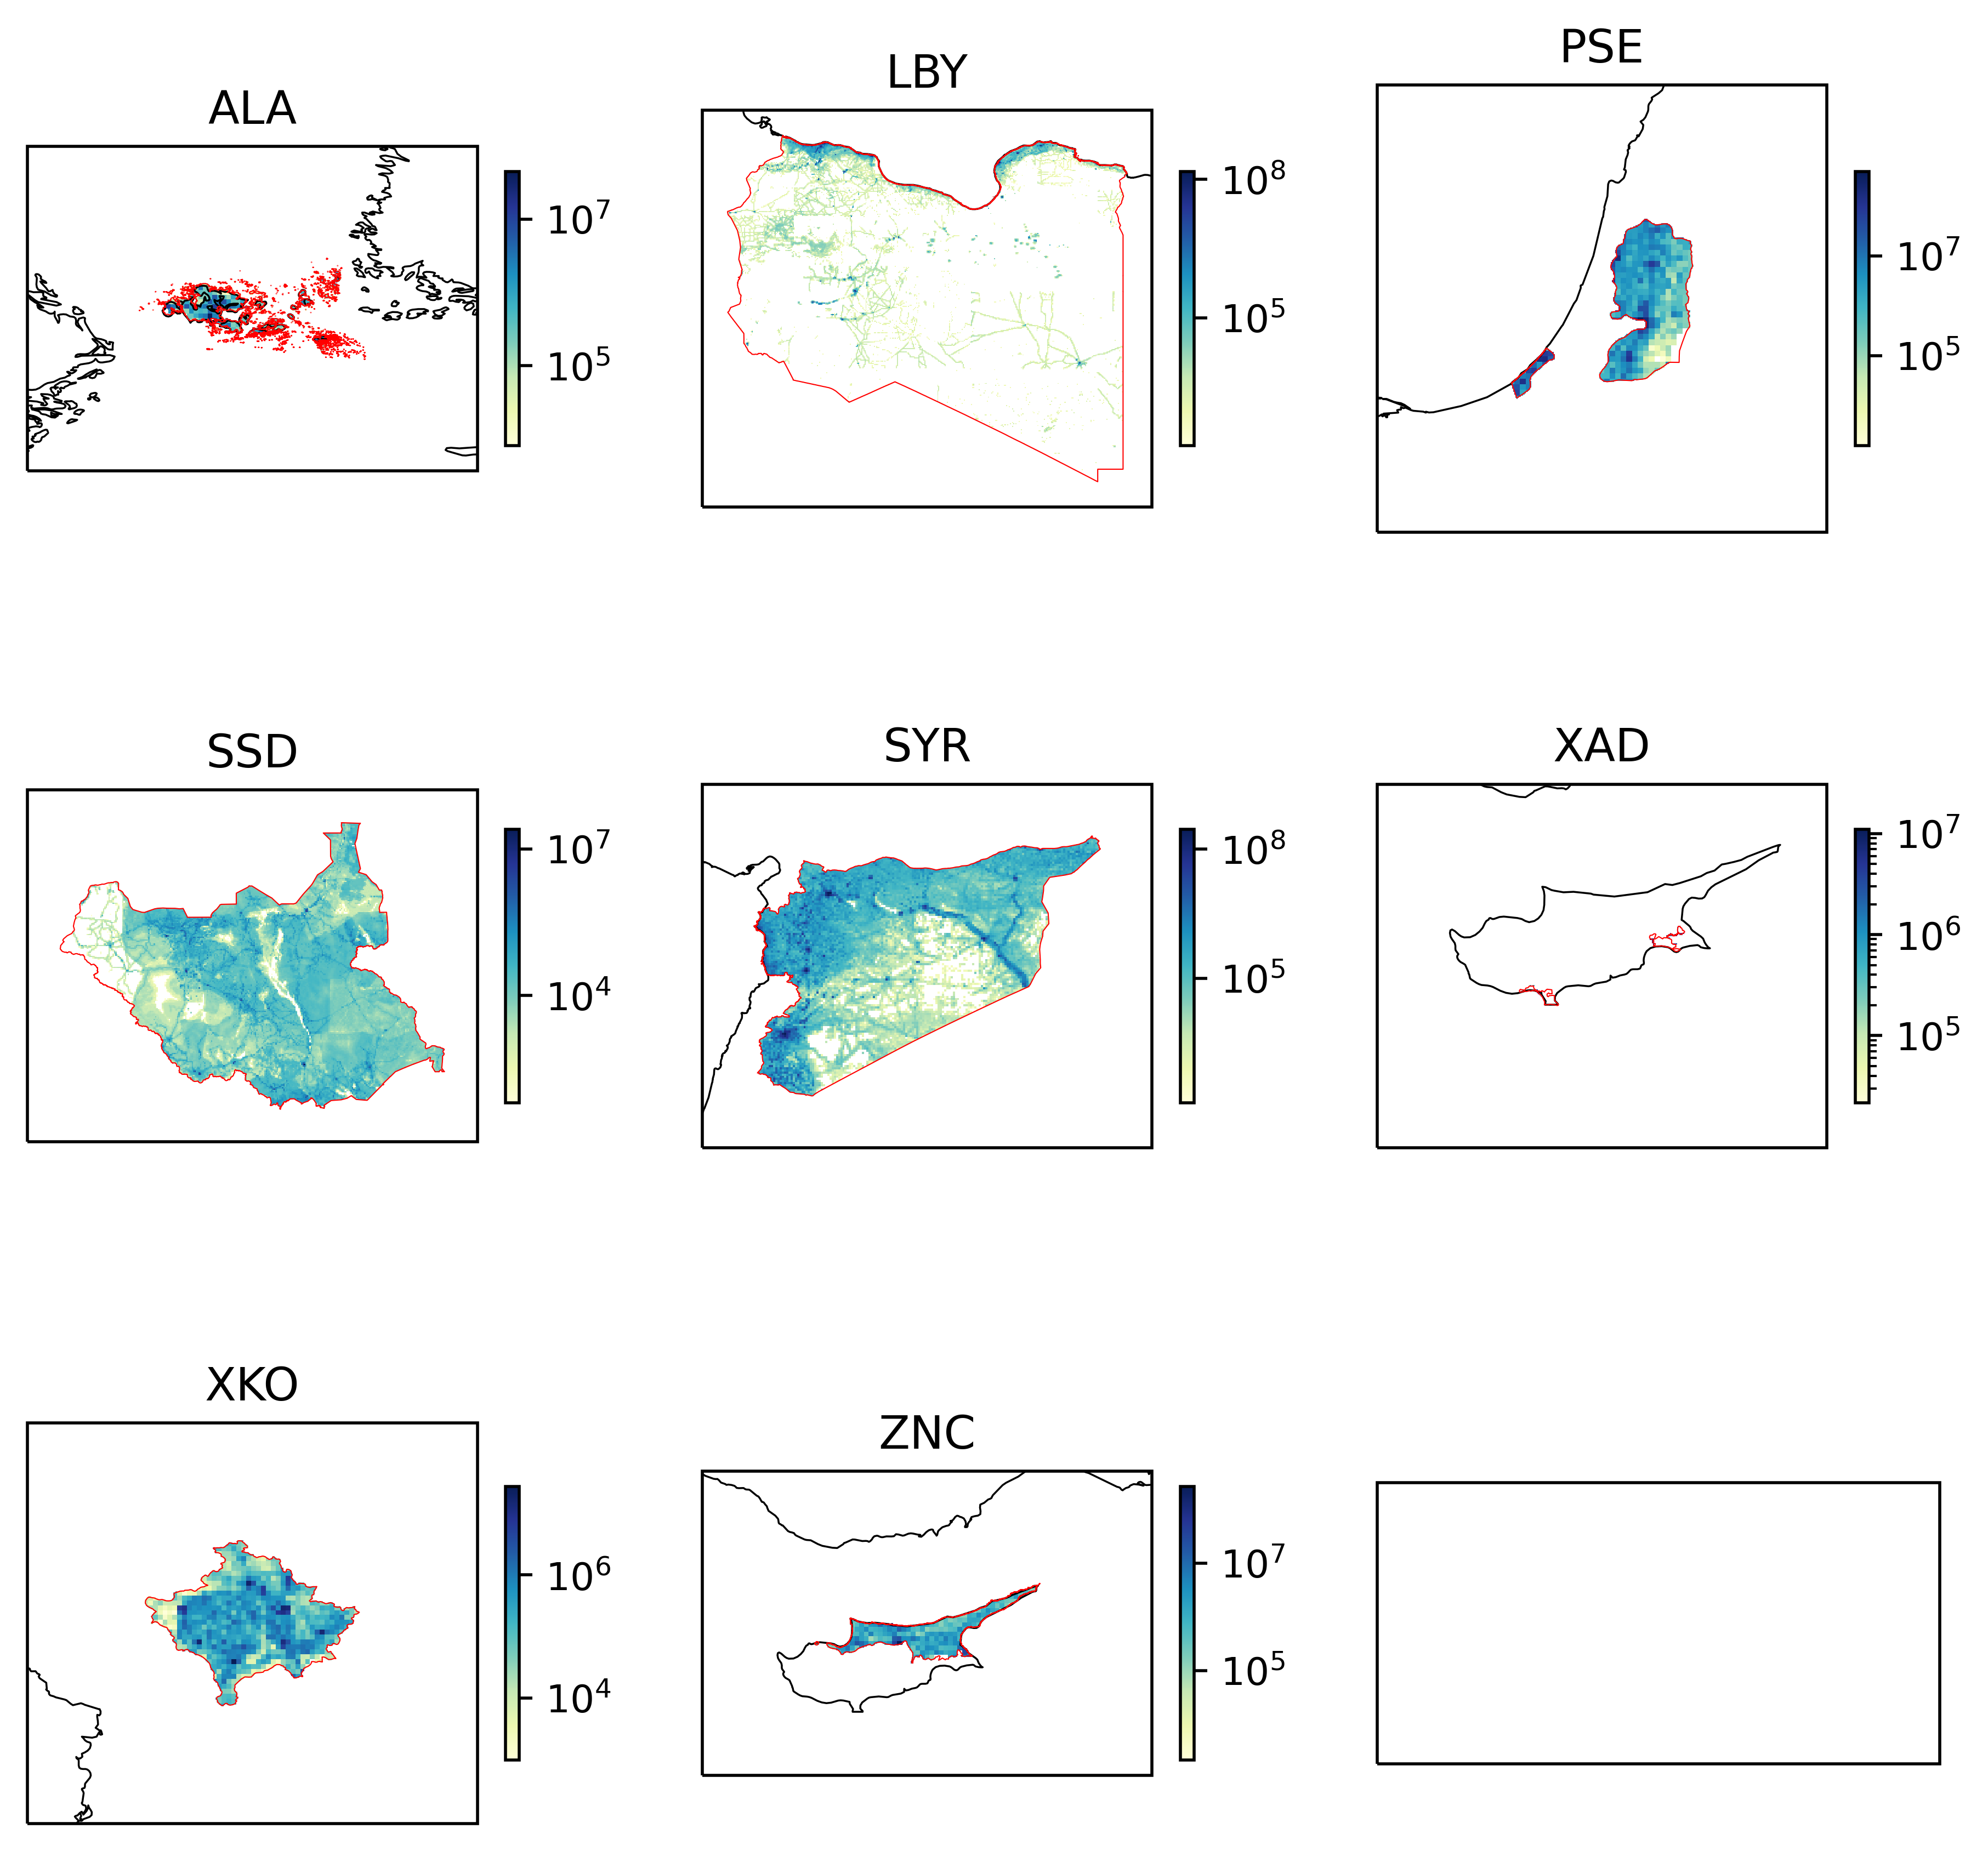

In [15]:
# How does the regridding look?
n_rows = ceil(len(fixed) / 3)
fig, axs = plt.subplots(
    figsize=((3 * 3), (3 * n_rows)),
    dpi=500,
    ncols=3,
    nrows=n_rows,
    subplot_kw={"projection": ccrs.PlateCarree()},
)

axs = axs.flatten()
for ax, tup in zip(axs, fixed.items()):
    plot_exposure(ax, tup[0], tup[1]["tot_val"], geoms[tup[0]])

Looks like XAD didn't actually get fixed either.

In [16]:
remaining.append("XAD")
remaining
out_dict["XAD"] = None

These are all quite small islands/areas so we'll just assume homogenous distribution within them.

## Add Regridded Data into LitPop

### First the countries/territories with no GEG

In [17]:
k_14 = (
    pd.read_parquet(sset.PATH_EXPOSURE_YPK_COUNTRY_HIST_INT)
    .rnna_19.to_xarray()
    .sel(year=2014, drop=True)
)

In [18]:
def assign_homogeneous(iso):
    this_bds = bds.loc[iso]
    ix = np.arange(
        grid_val_to_ix(
            this_bds.minx - sset.ASSET_VALUE_GRID_WIDTH / 2, sset.ASSET_VALUE_GRID_WIDTH
        ),
        grid_val_to_ix(
            this_bds.maxx + sset.ASSET_VALUE_GRID_WIDTH * 1.5,
            sset.ASSET_VALUE_GRID_WIDTH,
        ),
    )
    iy = np.arange(
        grid_val_to_ix(
            this_bds.miny - sset.ASSET_VALUE_GRID_WIDTH / 2, sset.ASSET_VALUE_GRID_WIDTH
        ),
        grid_val_to_ix(
            this_bds.maxy + sset.ASSET_VALUE_GRID_WIDTH * 1.5,
            sset.ASSET_VALUE_GRID_WIDTH,
        ),
    )
    lons = grid_ix_to_val(ix, sset.ASSET_VALUE_GRID_WIDTH)
    lats = grid_ix_to_val(iy, sset.ASSET_VALUE_GRID_WIDTH)

    da = xr.DataArray(1, coords={"lon": lons, "lat": lats}, dims=["lat", "lon"])

    mask = poly_mask(geoms[iso], da).astype(int)

    # make sure we're not double counting
    litpop_sub = (
        litpop.loc[
            (litpop.lon >= lons.min().item())
            & (litpop.lon <= lons.max().item())
            & (litpop.lat >= lats.min().item())
            & (litpop.lat <= lats.max().item()),
            ["lon", "lat", "value"],
        ]
        .compute()
        .set_index(["lat", "lon"])
        .value.to_xarray()
    )

    n_nonnull = litpop_sub.notnull().sum()

    litpop_sub["lon"] = grid_val_to_ix(
        litpop_sub.lon, sset.ASSET_VALUE_GRID_WIDTH, lon_mask=True
    )
    litpop_sub["lat"] = grid_val_to_ix(litpop_sub.lat, sset.ASSET_VALUE_GRID_WIDTH)
    litpop_sub = litpop_sub.reindex(lon=ix, lat=iy)
    litpop_sub["lon"] = grid_ix_to_val(
        litpop_sub.lon, sset.ASSET_VALUE_GRID_WIDTH, lon_mask=True
    )
    litpop_sub["lat"] = grid_ix_to_val(litpop_sub.lat, sset.ASSET_VALUE_GRID_WIDTH)

    litpop_sub = litpop_sub.reindex_like(mask)
    assert litpop_sub.notnull().sum() == n_nonnull

    mask = mask & litpop_sub.isnull()

    this_ctry_val = k_14.sel(ccode=iso).item()
    out = (this_ctry_val / mask.sum() * mask).to_series().rename("value")
    assert np.abs(out.sum() - this_ctry_val) < 1
    return out[out > 0].to_frame().assign(region_id=999, iso3=iso).reset_index()

In [19]:
addon = pd.concat([assign_homogeneous(iso) for iso in remaining])
assert addon.set_index(["lat", "lon"]).index.is_unique

In [20]:
litpop = ddf.concat([litpop, addon])

### Next, the countries that were filled with GEG

In [21]:
# swap from value to integer indexing
litpop["lat"] = litpop.lat.map_partitions(
    grid_val_to_ix, cell_size=sset.ASSET_VALUE_GRID_WIDTH
)
litpop["lon"] = litpop.lon.map_partitions(
    grid_val_to_ix, cell_size=sset.ASSET_VALUE_GRID_WIDTH
)
litpop = litpop.persist()

In [22]:
# add geg data into litpop dask dataframe
for iso, _add in [(k, v) for k, v in out_dict.items() if v is not None]:
    print(iso)
    add = _add.copy()
    add.coords["lat"] = grid_val_to_ix(add.lat.values, sset.ASSET_VALUE_GRID_WIDTH)
    add.coords["lon"] = grid_val_to_ix(add.lon.values, sset.ASSET_VALUE_GRID_WIDTH)

    litpop_sub = litpop[
        (litpop.lon >= add.lon.min().item())
        & (litpop.lon <= add.lon.max().item())
        & (litpop.lat >= add.lat.min().item())
        & (litpop.lat <= add.lat.max().item())
    ].compute()

    litpop_sub = litpop_sub.set_index(["lat", "lon"]).to_xarray()

    add = add.rename({"tot_val": "value"})

    add["iso3"] = (["lat", "lon"], np.where((~np.isnan(add["value"])), iso, None))

    litpop_sub["new_iso3"] = add["iso3"]
    litpop_sub["iso3"] = xr.where(
        litpop_sub["new_iso3"].isnull(), litpop_sub["iso3"], litpop_sub["new_iso3"]
    )
    litpop_sub["new_value"] = add["value"]
    litpop_sub["value"] = xr.where(
        litpop_sub["new_value"].isnull(), litpop_sub["value"], litpop_sub["new_value"]
    )

    mmed = xr.merge([litpop_sub[["value", "iso3"]], add[["value", "iso3"]]])

    litpop_m_sub = litpop[
        ~(
            (litpop.lon >= add.lon.min().item())
            & (litpop.lon <= add.lon.max().item())
            & (litpop.lat >= add.lat.min().item())
            & (litpop.lat <= add.lat.max().item())
        )
    ]

    to_append = (
        mmed[["value", "iso3"]]
        .reset_coords(drop=True)
        .to_dataframe()
        .dropna()
        .reset_index()
    )

    litpop = ddf.concat([litpop_m_sub, to_append]).persist()

ALA
LBY
PSE
SSD
SYR
XKO
ZNC


## Final check

In [43]:
# swap from value to integer indexing
litpop["lat"] = litpop.lat.map_partitions(
    grid_ix_to_val, cell_size=sset.ASSET_VALUE_GRID_WIDTH
)
litpop["lon"] = litpop.lon.map_partitions(
    grid_ix_to_val, cell_size=sset.ASSET_VALUE_GRID_WIDTH, lon_mask=True
)
litpop = litpop.persist()

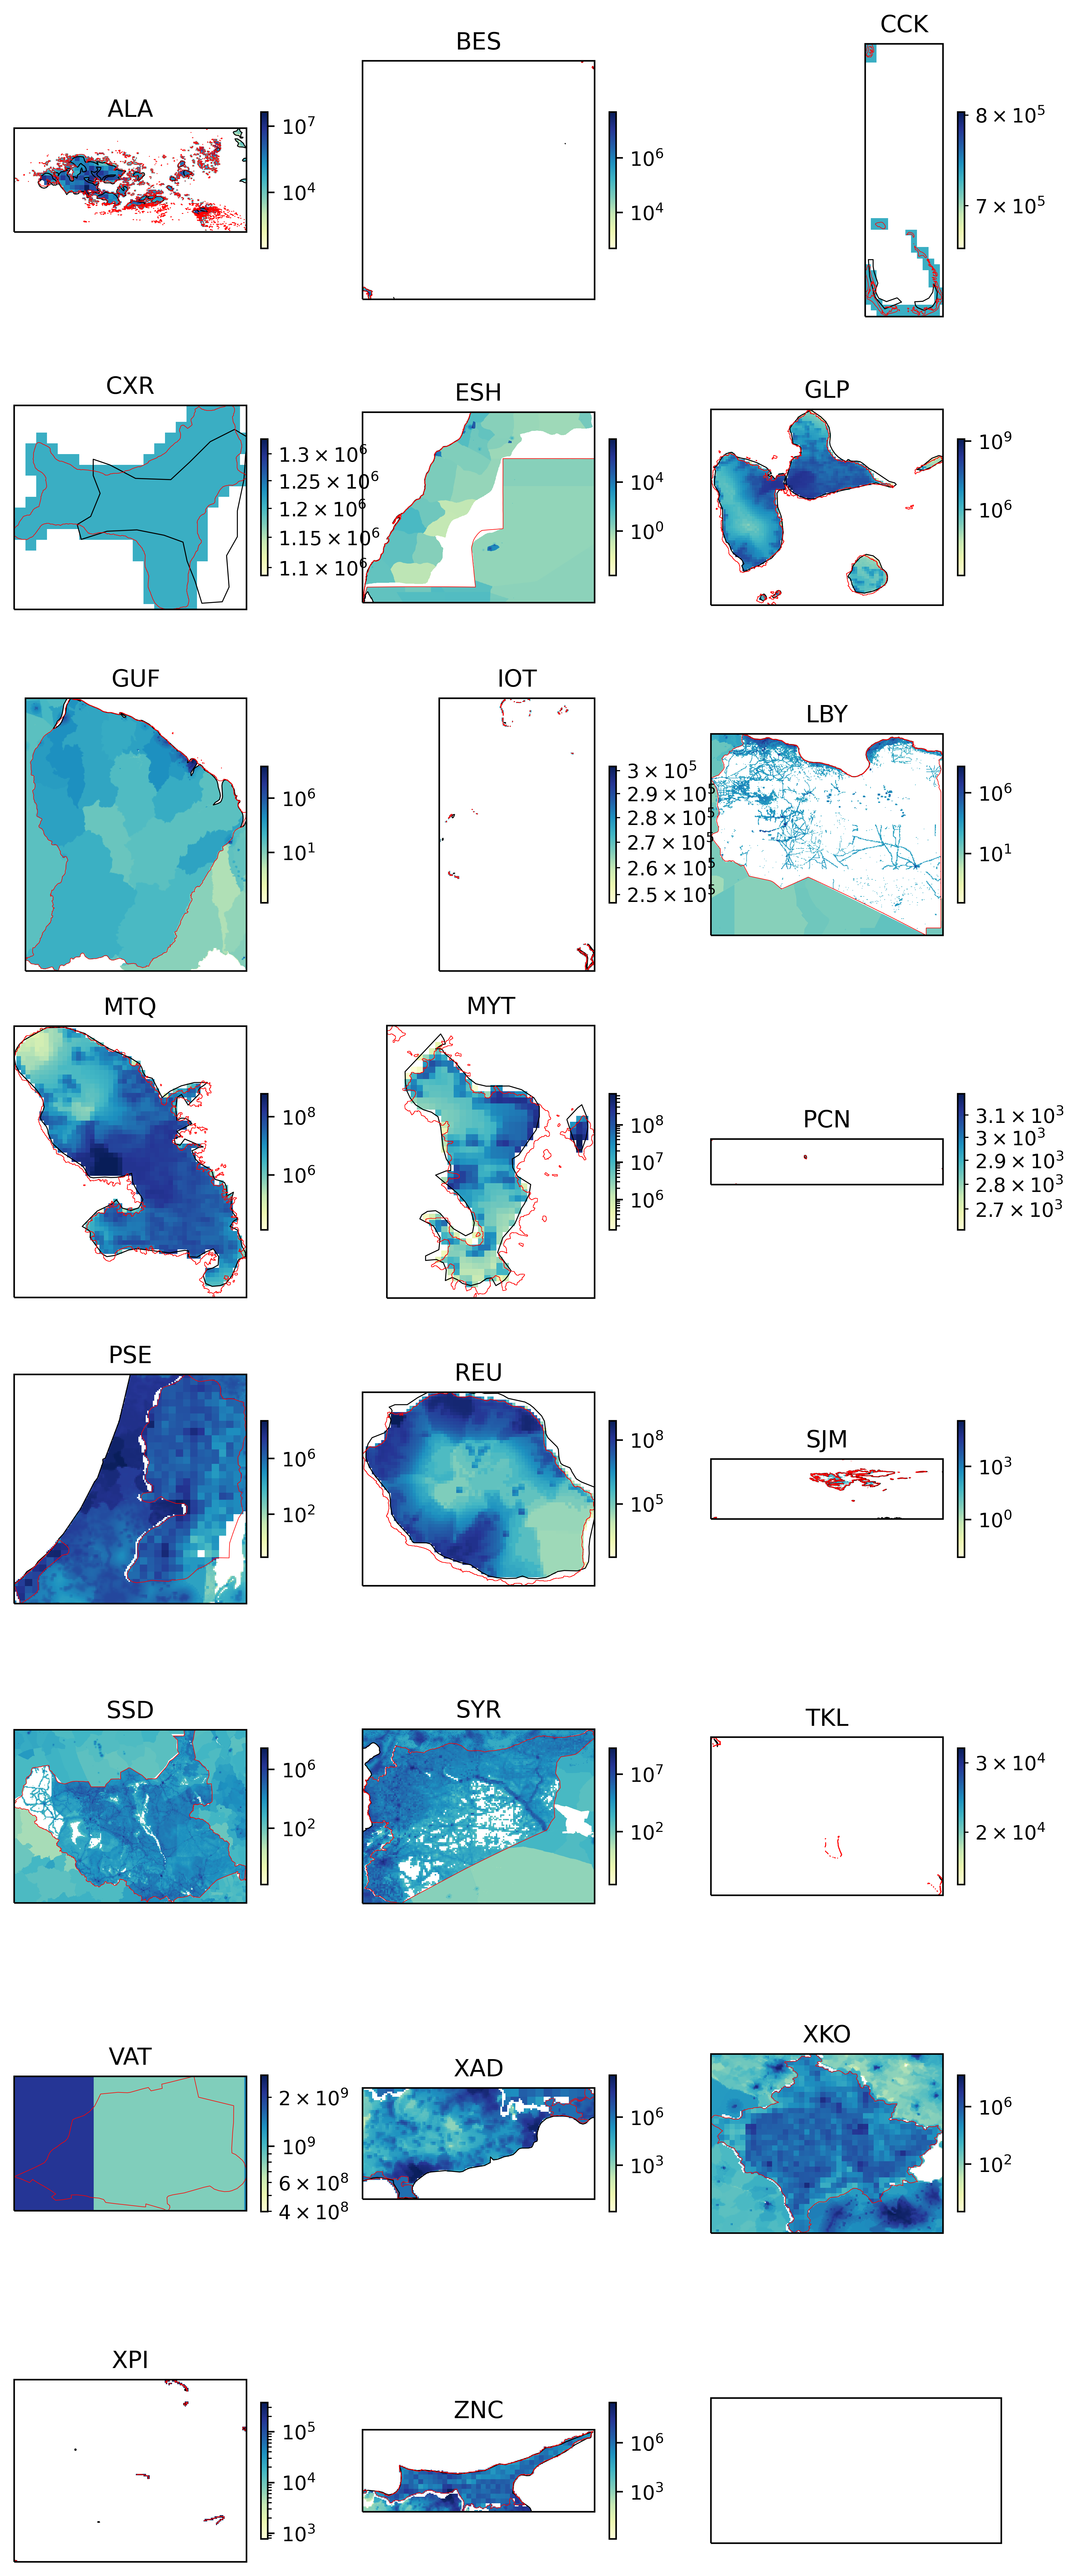

In [45]:
plot_exposure_multi(all_missing, bds, buffer=0)

## Save

In [53]:
# prep vars for saving
litpop["y_ix"] = litpop.lat.map_partitions(
    grid_val_to_ix, cell_size=sset.ASSET_VALUE_GRID_WIDTH
)
litpop["x_ix"] = litpop.lon.map_partitions(
    grid_val_to_ix, cell_size=sset.ASSET_VALUE_GRID_WIDTH, lon_mask=True
)
litpop["value"] = litpop["value"].astype(np.float32)
litpop = litpop.persist()

out_iso3 = litpop["iso3"].unique().compute()

litpop = litpop[["y_ix", "x_ix", "value"]]
litpop = litpop[litpop["value"] > 0].compute().reset_index(drop=True)

In [56]:
save(
    litpop,
    sset.PATH_EXPOSURE_ASSET_VALUE_BLENDED,
    index=False,
)

In [57]:
client.close(), cluster.close()

(None, None)